# Determining patterns that affect the success of computer games

Description: Streamchik online store sells computer games all over the world. Historical game sales data, user and expert ratings, genres and platforms (such as Xbox or PlayStation) are available from public sources. It is necessary to identify patterns that determine the success of the game. This will allow management to bid on a potentially popular product and plan advertising campaigns.

Data Description

* Name - the name of the game
* Platform - platform
* Year_of_Release - year of release
* Genre - game genre
* NA_sales - sales in North America (millions of copies sold)
* EU_sales - sales in Europe (millions of copies sold)
* JP_sales - sales in Japan (millions of copies sold)
* Other_sales - sales in other countries (millions of copies sold)
* Critic_Score - Critics score (maximum 100)
* User_Score - user score (maximum 10)
* Rating - rating from the ESRB (Entertainment Software Rating Board). This association determines the rating of computer games and assigns them an appropriate age category.

## Examining data from a file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
data = pd.read_csv('games.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


There are 16k rows in the table, in the rows with ratings and ratings - almost half of the data is missing.

## Data preprocessing

Let's do the following to preprocess the data:
* change the column names to lowercase
* replace the data type in year_of_release with datetime
* process gaps where necessary
* in the column with user rating there is an abbreviation tbd (To Be Determined), that is, "to be determined". Let's replace it with nan

In [3]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [4]:
data['year_of_release'] = pd.to_datetime(data['year_of_release'], format='%Y')

In [5]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [6]:
data = data.dropna(subset=['name', 'year_of_release', 'genre'])

In [7]:
data['rating'] = data['rating'].fillna('not determined')

In [8]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

In [9]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

**Conclusion:**

* Lines with gaps in name, year_of_release, genre - filtered out, because they make up less than 2% of the total data;
* In the rating column, because this is a categorical variable gaps changed to "not defined"
* Gaps in the columns with ratings (users and critics) - could have occurred due to the fact that the game has no ratings yet, you do not need to replace these gaps, because. there are too many of them to delete rows, and replacing with a median/mean is incorrect, because may skew the results in the future.
* Added a column with total sales for all regions

## Exploratory data analysis

First, let's look at how many games were released in different years to determine the trend; how sales by platform changed over the years and how many years the life cycle of a platform is approximately.

Since in further work there is no need to use the data of old periods, we will create a dataset with the current
period.

Let's determine what factors affect the volume of sales.

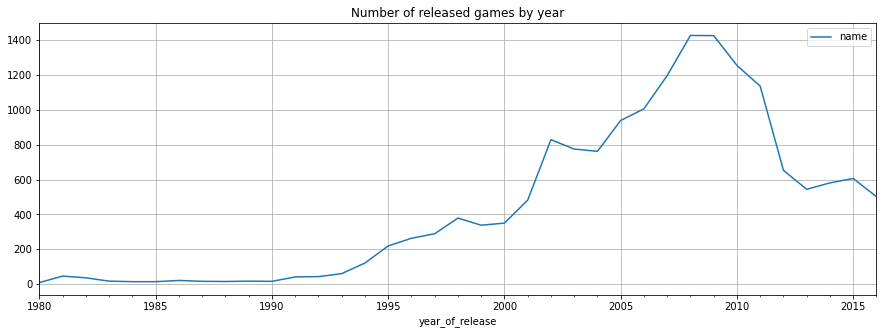

In [10]:
data.groupby(['year_of_release']).agg({'name':'count'}).reset_index().plot(x='year_of_release', grid=True, figsize=(15,5)).set_title("Number of released games by year");

"Boom" in the release of computer games - 2008-2009: more than 1400. For further analysis - we will consider only the last years: 2009-2016.

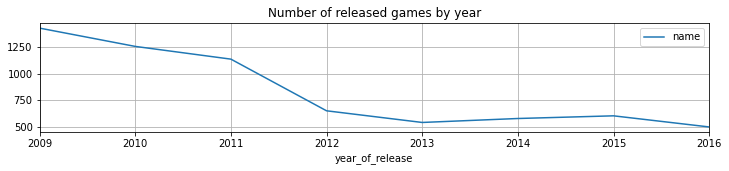

In [11]:
data.query('year_of_release >= 2009').groupby(['year_of_release']).agg({'name':'count'}).reset_index().plot(x='year_of_release', grid=True, figsize=(12,2)).set_title("Number of released games by year");

If we consider the last 8 years, then the number of released games by 2016 is declining.

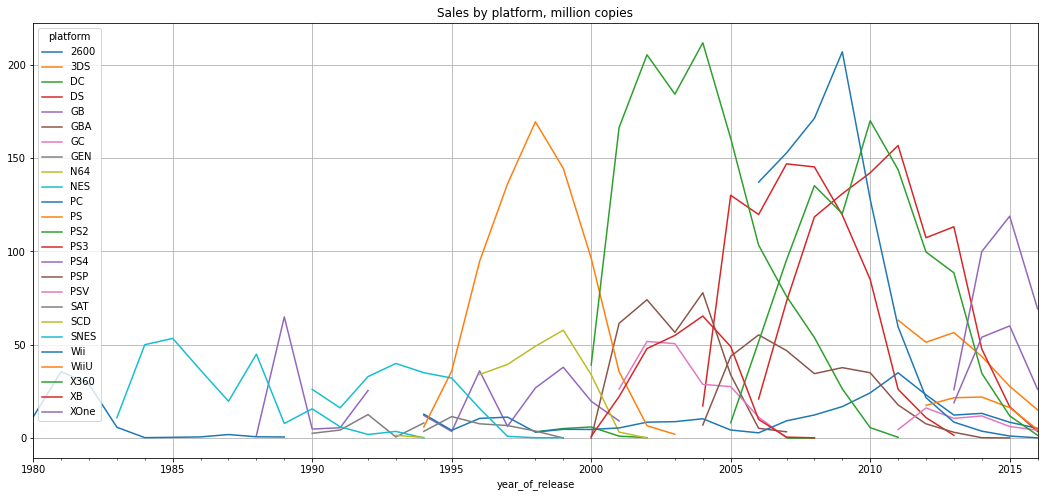

In [12]:
platform_sales = data.groupby(['platform']).agg({'total_sales':'sum'}).sort_values(by='total_sales').tail(25).index
data.query('platform in @platform_sales').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(18,8)).set_title("Sales by platform, million copies");

A few observations from the graph:

* since about 2005, the variety of platforms has increased
* sales of games on various platforms have their peak, then due to the emergence of newer models, sales on older ones fall sharply; the period of use of a certain platform model is about 8 years
* in 2015-2016 the most popular platform is PS4 and XOne.

In [13]:
actual_period = data.groupby(['platform', 'year_of_release']).agg({'total_sales': 'sum'}).query('total_sales > 1')
actual_period = actual_period.reset_index().groupby('platform').agg({'year_of_release': 'count'})
actual_period.mean()

year_of_release    7.92
dtype: float64

The estimated value of the life of the platform corresponds to what was previously determined using the graph - 8 years. But since the field of computer games is a rapidly developing one, for further analysis we will use data for the last 3 years.

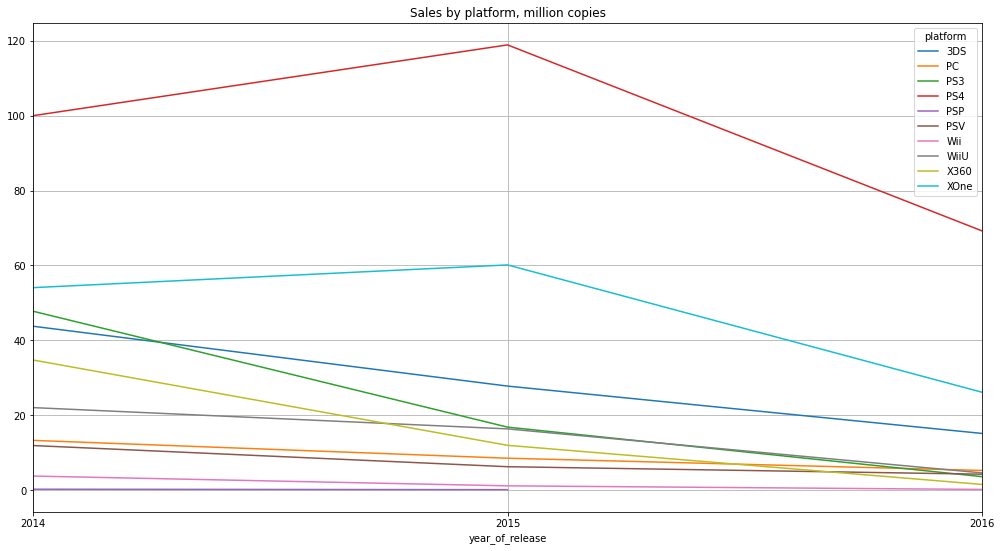

In [14]:
data.query('platform in @platform_sales and year_of_release >= 2014').pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').plot(grid=True, figsize=(17,9)).set_title("Sales by platform, million copies");

In 2016, the newest (at that time) PS4 model leads in sales. In second place is the XOne game console, in third place is the 3DS. Judging by the graph, sales across all platforms are falling by 2016, but since The data are incomplete, so it is incorrect to draw such a conclusion based on them.

In [15]:
data_new = data.query('year_of_release >= 2014')

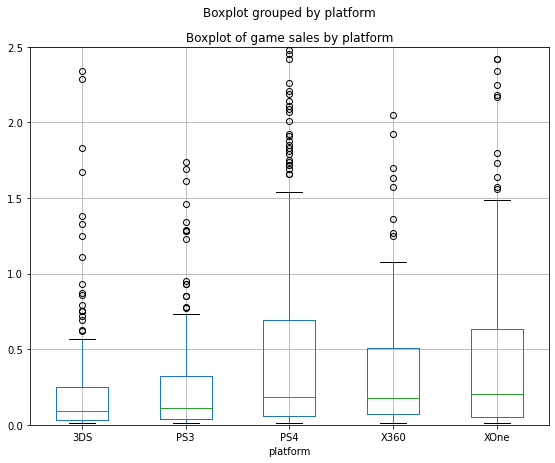

In [16]:
import warnings
warnings.filterwarnings('ignore')
data_new.query('platform in ["PS4","XOne","3DS", "PS3", "X360"]').boxplot(column='total_sales', by = 'platform', grid=True, figsize=(9,7)).set_title("Boxplot of game sales by platform")
plt.ylim(0,2.5);

According to the resulting graph, you can compare the median sales values for the most popular platforms for the current period. PS3 has the highest median sales value (but sales tend to 0 by 2015-2016 due to the newer PS4 model), followed by XOne and 3DS. I would also like to note that the latest PS4 and XOne models have a larger spread of values.

On the example of one of the popular and relevant PS4 platforms, let's determine the impact on sales of user reviews and critics. To do this, we calculate the correlation coefficient and construct a scatterplot.

In [17]:
data_new['user_score'] = data_new['user_score'].astype(float) #for calculation it is necessary to convert the type to float
data_new.query('platform == "PS4"')['total_sales'].corr(data_new['user_score']).round(2)

-0.04

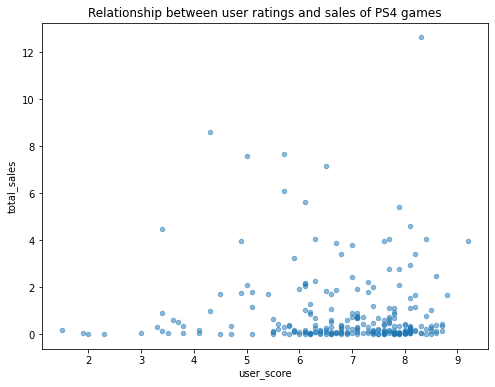

In [18]:
data_new.query('platform == "PS4"').plot(kind = 'scatter', x='user_score', y = 'total_sales', alpha = 0.5, figsize=(8,6)).set_title("Relationship between user ratings and sales of PS4 games");

Based on the obtained correlation coefficient, we can conclude that there is no linear relationship between user ratings and sales. However, the scatterplot shows that there is a non-linear relationship between the parameters.

In [19]:
data_new['critic_score'] = data_new['critic_score'].astype(float) #for calculation it is necessary to convert the type to float
data_new.query('platform == "PS4"')['total_sales'].corr(data_new['critic_score']).round(2)

0.4

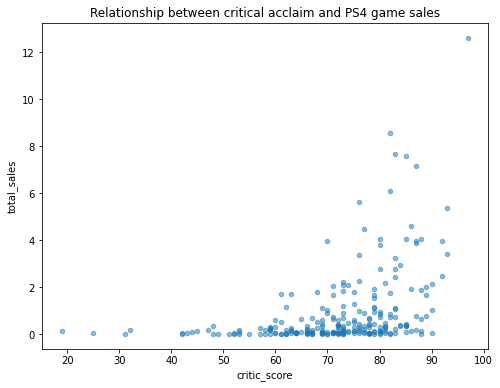

In [20]:
data_new.query('platform == "PS4"').plot(kind = 'scatter', x='critic_score', y = 'total_sales', alpha = 0.5, figsize=(8,6)).set_title("Relationship between critical acclaim and PS4 game sales");

The correlation coefficient and the scatterplot show that the rating of critics has a stronger effect on sales than the rating of users. As you can see from the graph, PS4 game sales are higher at a score of 70-90 than at a score of 20-60.

Now let's see if the same dependency remains for other popular platforms.

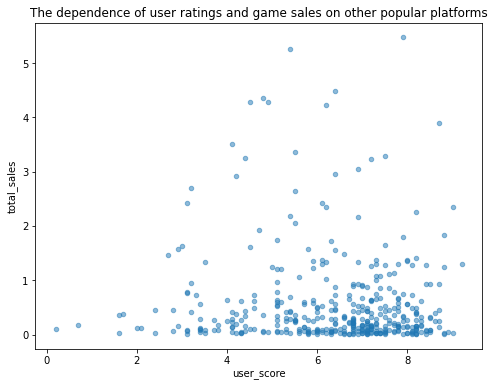

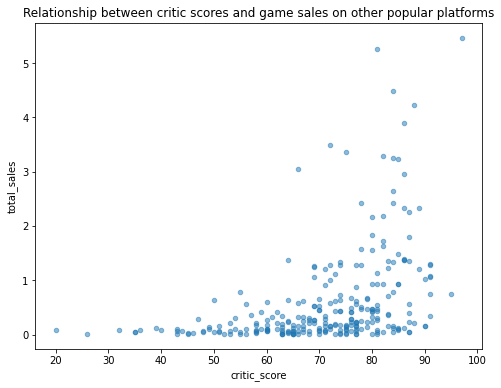

In [21]:
data_new.query('platform in ["3DS", "PS3", "X360", "XOne"]').plot(kind = 'scatter', x='user_score', y = 'total_sales', alpha = 0.5, figsize=(8,6)).set_title("The dependence of user ratings and game sales on other popular platforms");
data_new.query('platform in ["3DS", "PS3", "X360", "XOne"]').plot(kind = 'scatter', x='critic_score', y = 'total_sales', alpha = 0.5, figsize=(8,6)).set_title("Relationship between critic scores and game sales on other popular platforms");

In [22]:
data_new.query('platform in ["3DS", "PS3", "X360", "XOne"]')['total_sales'].corr(data_new['user_score']).round(2)

-0.05

In [23]:
data_new.query('platform in ["3DS", "PS3", "X360", "XOne"]')['total_sales'].corr(data_new['critic_score']).round(2)

0.42

For other popular platforms, the same situation is observed: there is no linear dependence, or it is weak in terms of the critics' assessment parameter. But the graphs show a non-linear relationship, i.e. with a higher estimate - sales of games more.

Let's see the distribution of games by genre: which of them are the most profitable.

In [24]:
data_new['genre'].value_counts()

Action          619
Role-Playing    221
Adventure       185
Sports          161
Shooter         128
Misc            113
Racing           69
Fighting         60
Simulation       44
Platform         38
Strategy         37
Puzzle           14
Name: genre, dtype: int64

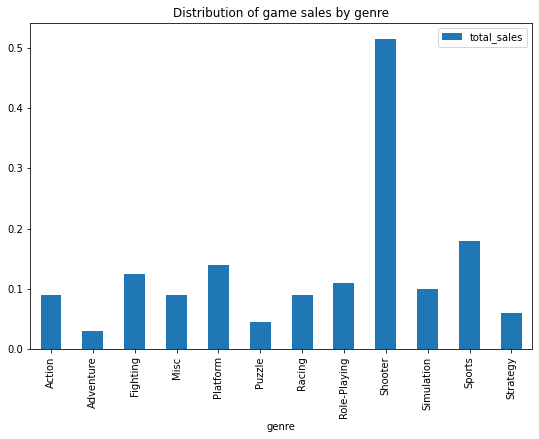

In [25]:
data_new.pivot_table(index='genre', values='total_sales', aggfunc='median').plot(kind='bar', title="Distribution of game sales by genre", figsize=(9,6));

The most profitable genres are "shooters" (thrillers); in second place - sports. Among the genres with the lowest sales are puzzles and adventures.

**Conclusion:**

At the stage of exploratory analysis, the life cycle of the platform is determined - 8 years, the most popular platforms for the current period of 2014-2016 are PS4, XOne and 3DS. The dependence of sales on the assessment of users and critics was revealed, and the assessment of critics has a stronger effect on sales. Based on the median value of sales, the most popular genres were identified: Shooter and Sports.

## User portrait by region

In this section, let's see how user preferences differ by region: North America, Europe, Japan.

* Which platforms are popular in each region
* Which genres users prefer by region
* How sales are affected by ESRB rating in different regions

Let's display the top 5 most popular platforms for the user of each region.

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05


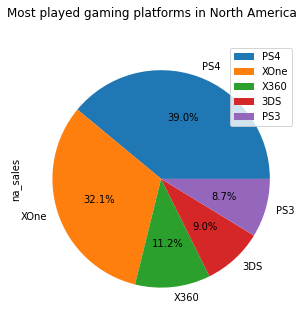

In [26]:
na_platform = data_new.pivot_table(index='platform', values=['na_sales'], aggfunc=sum).sort_values(by='na_sales', ascending=False).head()
display(na_platform) 
na_platform.plot.pie(subplots=True, figsize=(10,5), autopct='%1.1f%%', 
                     title="Most played gaming platforms in North America")
plt.show()

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12


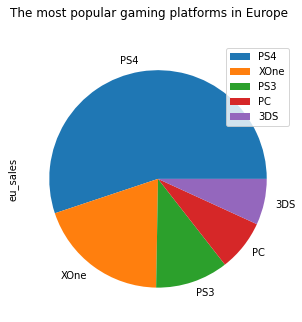

In [27]:
eu_platform = data_new.pivot_table(index='platform', values=['eu_sales'], aggfunc=sum).sort_values(by='eu_sales', ascending=False).head()
display(eu_platform) 
eu_platform.plot.pie(subplots=True, figsize=(10,5), title="The most popular gaming platforms in Europe");

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31


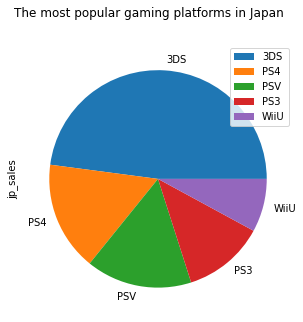

In [28]:
jp_platform = data_new.pivot_table(index='platform', values=['jp_sales'], aggfunc=sum).sort_values(by='jp_sales', ascending=False).head()
display(jp_platform) 
jp_platform.plot.pie(subplots=True, figsize=(10,5), title="The most popular gaming platforms in Japan");

,other_sales
platform,
PS4,44.48
XOne,12.52
PS3,9.37
X360,4.35
3DS,3.68


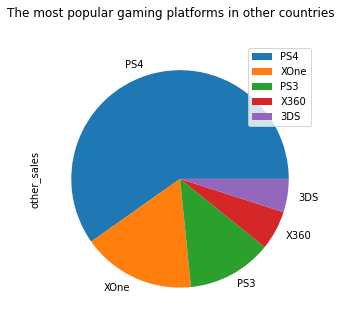

In [29]:
other_platform = data_new.pivot_table(index='platform', values=['other_sales'], aggfunc=sum).sort_values(by='other_sales', ascending=False).head()
display(other_platform) 
other_platform.plot.pie(subplots=True, figsize=(10,5), title="The most popular gaming platforms in other countries");

**Conclusion:**

In different regions, users prefer different platforms. In North America, the X360 is the most popular console, and in Europe, the Play Station 3, in Japan, the Nintendo 3DS platform is generally in the lead.

In [30]:
# Most popular genres by region
na_genre = data_new.pivot_table(index='genre', values=['na_sales'], aggfunc=sum).sort_values(by='na_sales', ascending=False).head()
display(na_genre)
eu_genre = data_new.pivot_table(index='genre', values=['eu_sales'], aggfunc=sum).sort_values(by='eu_sales', ascending=False).head()
display(eu_genre)
jp_genre = data_new.pivot_table(index='genre', values=['jp_sales'], aggfunc=sum).sort_values(by='jp_sales', ascending=False).head()
display(jp_genre)
other_genre = data_new.pivot_table(index='genre', values=['other_sales'], aggfunc=sum).sort_values(by='other_sales', ascending=False).head()
display(other_genre)

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


,other_sales
genre,
Action,22.57
Shooter,21.53
Sports,14.36
Role-Playing,8.64
Misc,4.03


In almost all countries, the Actoin genre is in the lead, followed by Shooter. Interestingly, in Japan, users prefer the Role-Playing genre.

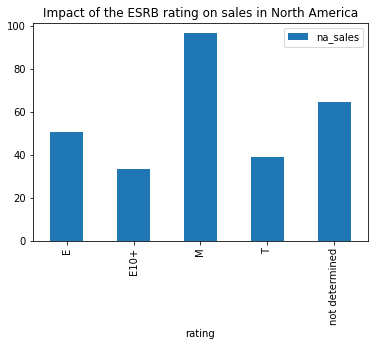

In [31]:
# Let's see with the help of a graph whether the ESRB rating affects sales in a particular region
data_new.pivot_table(index='rating', values='na_sales', aggfunc=sum).plot(kind='bar')
plt.title('Impact of the ESRB rating on sales in North America');

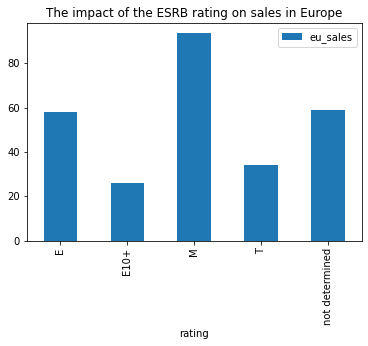

In [32]:
data_new.pivot_table(index='rating', values='eu_sales', aggfunc=sum).plot(kind='bar')
plt.title('The impact of the ESRB rating on sales in Europe');

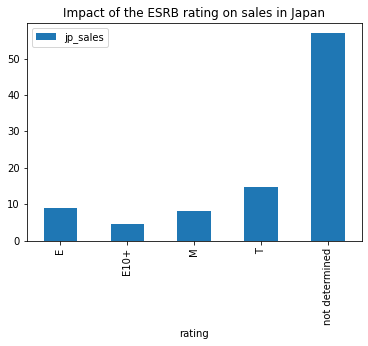

In [33]:
data_new.pivot_table(index='rating', values='jp_sales', aggfunc=sum).plot(kind='bar')
plt.title('Impact of the ESRB rating on sales in Japan');

The graphs show that the highest sales in North America and Europe are for games with an "M" rating, from 17 years old. In Japan, unfortunately, most of the games are not rated; and games with a rating of "T" are in the lead, i.e. "teen", teenagers from 13 years old.

## Testing hypotheses
Let's test 2 hypotheses:
1. The average user ratings of the Xbox One and PC platforms are the same
2. The average user ratings of the genres Action and Sports are different.

In [34]:
# Remove all gaps in columns before testing hypotheses
data_new = data_new.dropna(subset=['user_score'])
data_new.query('platform in ["PC", "XOne"]').pivot_table(index='platform', values='user_score', aggfunc='mean').round(2)

,user_score
platform,
PC,6.30
XOne,6.59


1: Hypothesis test of equality of the average user rating of the Xbox One and PC platforms.

Null hypothesis H₀: the average user rating of the Xbox One platform is equal to PC.

Alternative Hypothesis H₁: The average user rating of the Xbox One and PC platform is different.

In [35]:
user_score_xbox = data_new[data_new['platform'] == 'XOne']['user_score']
user_score_pc = data_new[data_new['platform'] == 'PC']['user_score']

alpha = 0.01 # critical level of statistical significance
# if p-value is less than it, we reject the hypothesis

results = st.ttest_ind(user_score_xbox, user_score_pc)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value:  0.10450507919348415
Failed to reject the null hypothesis


It will not be possible to reject the null hypothesis. The calculated value also shows that the user ratings for PC and XOne are the same - 6 points.

In [36]:
data_new.query('genre in ["Action", "Sports"]').pivot_table(index='genre', values='user_score', aggfunc='mean').round(2)

,user_score
genre,
Action,6.76
Sports,5.23


2: Testing the hypothesis about the difference between the average user ratings of Action and Sports genres.

Null hypothesis H₀: the average user ratings of the Action and Sports genres are equal.

Alternative H₁ Hypothesis: Average User Ratings for Action and Sports Are Different.

In [37]:
user_score_action = data_new[data_new['genre'] == 'Action']['user_score']
user_score_sports = data_new[data_new['genre'] == 'Sports']['user_score']

alpha = 0.01 # critical level of statistical significance
# if p-value is less than it, we reject the hypothesis

results = st.ttest_ind(user_score_action, user_score_sports)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("Rejecting the null hypothesis")
else:
    print("Failed to reject the null hypothesis")

p-value:  2.8711147985105864e-19
Rejecting the null hypothesis


The null hypothesis of equality must be rejected, a p-value of almost 0 indicates that, with a probability of 99%, the average user ratings of the sports genre and the action game are different; according to the calculated value, rating Action - 7, Sports - 5.

## General conclusion

As a result of the analysis of data on sales of computer games on various platforms, first of all, the "lifetime" of one platform model was determined to perform further calculations only for the current period (because the original dataset contains data from the 80s) - about 8 years.

The most popular consoles over the past 3 years are PS4, XOne, 3DS.

The most popular genres by a wide margin are Shooter and Sports, they are in the lead in almost all countries except Japan, where users prefer Role-Playing.

In addition, when planning an advertising campaign, it is worth considering that users use different platforms in different regions: Play Station 4 in North America and Europe, 3DS in Japan.

Various ratings also affect sales: user and critic ratings, as well as the ESRB rating (the highest sales for "M" are from 17 years old).